In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import arma_order_select_ic

from sklearn.metrics import mean_squared_error
from ipywidgets import interact, FloatSlider, Dropdown

#!pip install plotly
# !pip install voila

In [2]:
power_train = pd.read_csv('./datasets/power_train.csv', index_col=0)
power_train.index = pd.DatetimeIndex(power_train.index, freq='H')

power_val_data = pd.read_csv('./datasets/power_val_data.csv', index_col=0)
power_val_data.index = pd.DatetimeIndex(power_val_data.index)

power_val_target = pd.read_csv('./datasets/power_val_target.csv', index_col=0)
power_val_target.index = pd.DatetimeIndex(power_val_target.index)

power_val_benchmark = pd.read_csv('./datasets/power_val_benchmark.csv', index_col=0)
power_val_benchmark.index = pd.DatetimeIndex(power_val_benchmark.index)

# restrict analysis to one wind farm

wp5_train = power_train['wp5']
wp5_val_data = power_val_data['wp5']
wp5_val_target = power_val_target['wp5']
wp5_val_benchmark = power_val_benchmark['wp5']

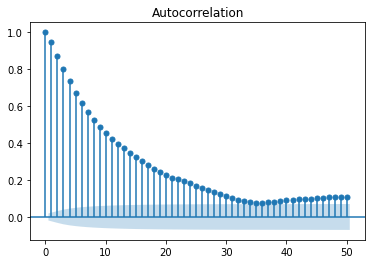

In [3]:
plot_acf(wp5_train, lags=50);

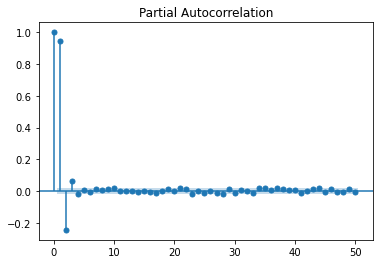

In [4]:
plot_pacf(wp5_train, lags=50);

In [5]:
p = 2 # num of autoregressive terms
q = 0 # num of MA terms

# use SARIMAX for additional functionality later on
ar2 = sarimax.SARIMAX(endog = wp5_train, order = (p,0,q)).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    wp5   No. Observations:                10453
Model:               SARIMAX(2, 0, 0)   Log Likelihood               10804.466
Date:                Tue, 07 Sep 2021   AIC                         -21602.932
Time:                        09:55:47   BIC                         -21581.168
Sample:                    07-01-2009   HQIC                        -21595.582
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1910      0.005    218.030      0.000       1.180       1.202
ar.L2         -0.2278      0.005    -41.615      0.000      -0.239      -0.217
sigma2         0.0074   4.37e-05    169.428      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):             36861.08
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
def forecast_48_from_36(model, data):
    
    '''forecasts 48 hours of power output given one 36 hour window of available data'''
    
    # reset index frequency to hourly - this was lost before when slicing up the date-time index
    # need this so the model knows how frequently to make predictions
    data.index = pd.DatetimeIndex(data.index, freq='H')
    # reinstantiate model, but use old parameters
    p = model.model_orders['ar']
    q = model.model_orders['ma']
    model_temp = sarimax.SARIMAX(endog = data, order = (p,0,q))
    model_temp = model_temp.filter(model.params)
    # forecast
    return model_temp.get_forecast(48)

In [7]:
def make_forecasts(model, data_series):
        
    '''forecasts many sets of 48 hours of power output given repeated 36 hour windows of available data'''
    
    predictions = []
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    
    for pattern_num in range(num_patterns):
        data = data_series[36*pattern_num:36*(pattern_num+1)]
        forecast = forecast_48_from_36(model, data).predicted_mean
        predictions.extend(forecast)
    
    ix = pd.date_range(start=data_series.index[0], end=data_series.index[-1]+pd.Timedelta(hours=48), freq='H')
    forecast_ix = [date for date in ix if date not in data_series.index]
    
    return pd.DataFrame(predictions, columns=['forecast'], index = forecast_ix)

In [8]:
ar2_predictions = make_forecasts(ar2, wp5_val_data)
ar2_RMSE = mean_squared_error(y_true = wp5_val_target, y_pred = ar2_predictions)**0.5
print('AR2 model RMSE:', ar2_RMSE)

AR2 model RMSE: 0.35173262776048875


In [9]:
# investigate AICs for various p,q values
arma_order_select_ic(wp5_train, max_ar = 4, max_ma = 2, ic= 'aic')

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and stat

{'aic':               0             1             2
 0   2363.866957  -8615.152949 -14337.352326
 1 -21175.486490 -21857.769422 -21855.770225
 2 -21809.191138 -21855.770249 -21864.275284
 3 -21851.160625 -21853.932561 -21852.091378
 4 -21853.228859 -21852.104091 -21850.131015,
 'aic_min_order': (2, 2)}

In [10]:
# investigate BICs for various p,q values
arma_order_select_ic(wp5_train, max_ar = 4, max_ma = 2, ic= 'bic')

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and stat

{'bic':               0             1             2
 0   2378.376246  -8593.389016 -14308.333749
 1 -21153.722557 -21828.750845 -21819.497004
 2 -21780.172561 -21819.497028 -21820.747418
 3 -21814.887403 -21810.404695 -21801.308868
 4 -21809.700993 -21801.321581 -21792.093861,
 'bic_min_order': (1, 1)}

In [11]:
# both information criterions suggest an AR(1)MA(2) model will fit best, so try this
ar1ma2 = sarimax.SARIMAX(endog = wp5_train, order = (1,0,2)).fit()
ar1ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    wp5   No. Observations:                10453
Model:               SARIMAX(1, 0, 2)   Log Likelihood               10839.499
Date:                Tue, 07 Sep 2021   AIC                         -21670.997
Time:                        09:56:45   BIC                         -21641.979
Sample:                    07-01-2009   HQIC                        -21661.196
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9576      0.002    409.583      0.000       0.953       0.962
ma.L1          0.2527      0.006     43.604      0.000       0.241       0.264
ma.L2         -0.0205      0.007     -3.040      0.002      -0.034      -0.007
sigma2         0.0074   4.36e-05    168.849      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):             36719.54
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
ar1ma2_predictions = make_forecasts(ar1ma2, wp5_val_data)
ar1ma2_RMSE = mean_squared_error(y_true = wp5_val_target, y_pred = ar1ma2_predictions)**0.5
print('AR(1)MA(2) model RMSE:', ar1ma2_RMSE)

AR(1)MA(2) model RMSE: 0.34631083619558756


In [13]:
# evaluate combinations of p, d and q values for an ARIMA model
def find_best_ARIMA_params(training_data, testing_data, target, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try: # use a try clause as MA models can't always find a solution
                    np.random.seed(42)
                    model = sarimax.SARIMAX(endog = training_data, order = order).fit()
                    if model.mle_retvals['converged']: # only use solution if converged
                        preds = make_forecasts(model, testing_data)
                        rmse = mean_squared_error(y_true = target, y_pred = preds)**0.5
                        if rmse < best_score:
                            best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (str(order), rmse))
                    else:
                        print('ARIMA%s failed to converge' % (str(order)))
                except:
                    print('ARIMA%s could not find a solution' % (str(order)))
    print('\nBest ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
# code adapted from: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [14]:
import warnings
warnings.filterwarnings('ignore') # suppress convergence warnings

best_params = find_best_ARIMA_params(training_data = wp5_train, 
                        testing_data = wp5_val_data,
                        target = wp5_val_target,
                        p_values = [0,1,2,3,4],
                        d_values = [0],
                        q_values = [0,1,2])

warnings.filterwarnings('default') # turn warnings back on

ARIMA(0, 0, 0) RMSE=0.458
ARIMA(0, 0, 1) RMSE=0.454
ARIMA(0, 0, 2) RMSE=0.451
ARIMA(1, 0, 0) RMSE=0.337
ARIMA(1, 0, 1) RMSE=0.348
ARIMA(1, 0, 2) RMSE=0.346
ARIMA(2, 0, 0) RMSE=0.352
ARIMA(2, 0, 1) RMSE=0.347
ARIMA(2, 0, 2) RMSE=0.348
ARIMA(3, 0, 0) RMSE=0.344
ARIMA(3, 0, 1) RMSE=0.345
ARIMA(3, 0, 2) RMSE=0.347
ARIMA(4, 0, 0) RMSE=0.345
ARIMA(4, 0, 1) RMSE=0.345
ARIMA(4, 0, 2) failed to converge

Best ARIMA(1, 0, 0) RMSE=0.337


In [15]:
ar1 = sarimax.SARIMAX(endog = wp5_train, order = (1,0,0)).fit()
ar1.summary()

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    wp5   No. Observations:                10453
Model:               SARIMAX(1, 0, 0)   Log Likelihood               10526.128
Date:                Tue, 07 Sep 2021   AIC                         -21048.256
Time:                        09:57:12   BIC                         -21033.747
Sample:                    07-01-2009   HQIC                        -21043.356
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9701      0.002    529.529      0.000       0.966       0.974
sigma2         0.0078   4.78e-05    163.250      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                 485.90   Jarque-Bera (JB):             29301.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
ar1_predictions = make_forecasts(ar1, wp5_val_data)
ar1_RMSE = mean_squared_error(y_true = wp5_val_target, y_pred = ar1_predictions)**0.5
print('AR(1) model RMSE:', ar1_RMSE)

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AR(1) model RMSE: 0.33656407003227806


/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


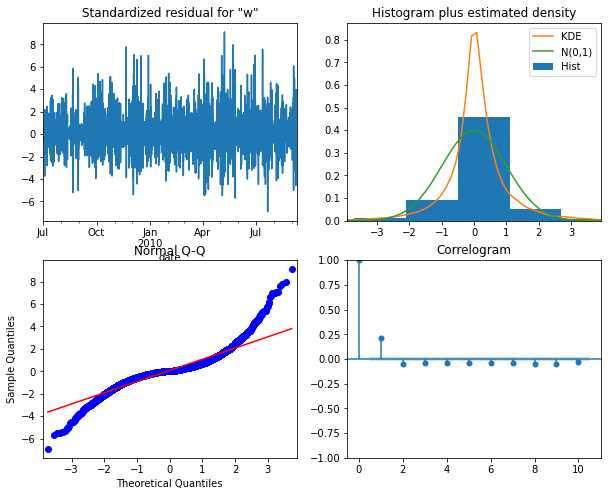

In [17]:
ar1.plot_diagnostics(figsize=(10,8));

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


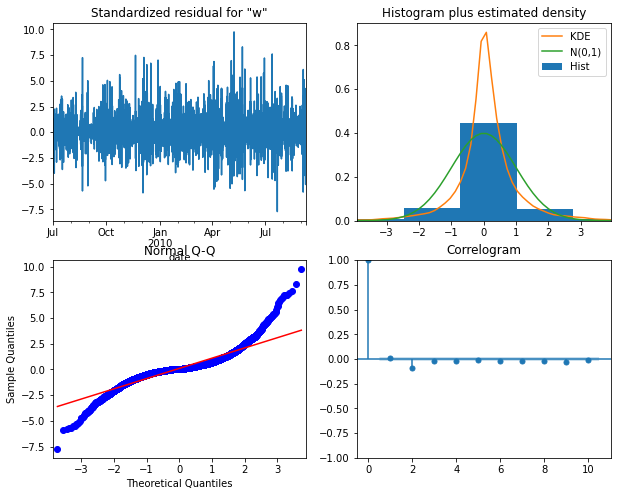

In [18]:
ar2.plot_diagnostics(figsize=(10,8));

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


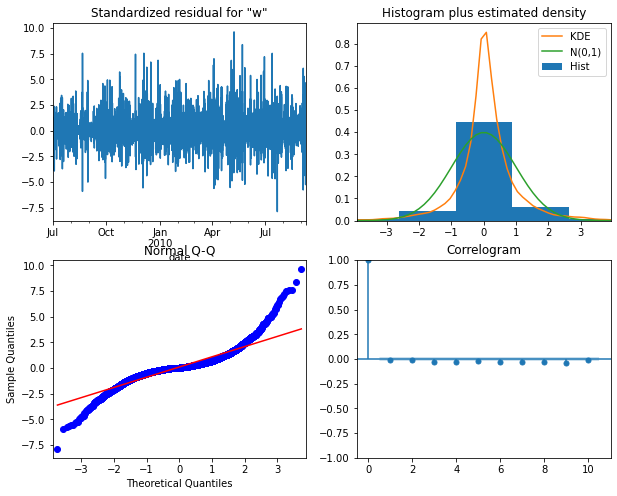

In [19]:
ar1ma2.plot_diagnostics(figsize=(10,8));

In [20]:
# save best model predictions
predictions = make_forecasts(ar2, wp5_val_data)
predictions.to_csv('./datasets/wp5_predictions_sarimax.csv')

/Users/afsara/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def make_widget(model, data_series, target_series = None, alt_prediction = None, alt_label = None):
    
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    windows = [str(i)+':  '+ str(data_series.index[36*i])+' - '+str(data_series.index[36*(i+1)-1]) for i in range(num_patterns)]
   
    style = {'description_width': 'initial'}
    
    window_select = Dropdown(
    options=windows,
    value=windows[0],
    description='Data window:',
    style = style,
    layout={'width': '400px'}
    )
    
    level_select = FloatSlider(
    value=0.95, min=0.01, max=0.99, step=0.01,
    description='Confidence level:',
    style = style,
    layout={'width': '400px'},
    continuous_update=False,
    )

    
    def plot_widget(data_window = windows[0], conf_level = 0.95):
    
        # filter dataframe
        data_window_int = int(data_window.split(':')[0])
        data = data_series[36*data_window_int:36*(data_window_int+1)]
        forecast = forecast_48_from_36(model, data)
        forecast_mean = forecast.predicted_mean
        conf_int = forecast.conf_int(alpha = (1-conf_level)) 
    
        # plot
        fig, ax = plt.subplots(figsize=(20,6))
        
        data.plot(label='observed data', c='purple')
        forecast.predicted_mean.plot(label='ARIMA forecast', ax=ax)
        ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=.2)
        
        if alt_prediction is not None:
            alt_forecast = alt_prediction[48*data_window_int:48*(data_window_int+1)]
            if isinstance(alt_forecast, pd.DataFrame):
                alt_forecast = alt_forecast['forecast']
            alt_forecast.plot(label=alt_label, ax=ax, c='C0', style='--')
                
        if target_series is not None:
            target = target_series[48*data_window_int:48*(data_window_int+1)]
            target.plot(label='target data', ax=ax, c='grey')
            forecast_RMSE = mean_squared_error(y_true = target, y_pred = forecast.predicted_mean)**0.5
            print('ARIMA forecast RMSE:', "{0:.2f}".format(forecast_RMSE))
            if alt_prediction is not None:
                alt_forecast_RMSE = mean_squared_error(y_true = target, y_pred = alt_forecast)**0.5
                print(str(alt_label), 'RMSE:', "{0:.2f}".format(alt_forecast_RMSE))
        
        ax.minorticks_off()
        idx = pd.date_range(data.index[0]-pd.Timedelta(hours=1), forecast.predicted_mean.index[-1], freq='H')
        ax.set_xlim(idx[0],idx[-1])
        ax.set_ylim(0,1)

        ax.set_xticks(idx[::12])
        ax.set_xticklabels(idx[::12].strftime('%Y-%m-%d\n%H:%M:%S'))
        
        plt.title('Comparing Power Output for Wind Farm 5', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Power output\n', fontsize=14)

        plt.legend()
        plt.show()
    
    interact(plot_widget, data_window=window_select, conf_level=level_select);

## Arima v Baseline

In [22]:
make_widget(model = ar2, data_series = wp5_val_data, target_series = wp5_val_target,
           alt_prediction = wp5_val_benchmark, alt_label = 'persistence forecast')

interactive(children=(Dropdown(description='Data window:', layout=Layout(width='400px'), options=('0:  2010-09…